In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/wimans/annotation.csv")

In [ ]:

df = df[["label", "number_of_users"]]

In [ ]:

print("Distribution of user counts:")
print(df['number_of_users'].value_counts())

Distribution of user counts:
number_of_users
1    3564
2    1782
3    1782
4    1782
5    1782
0     594
Name: count, dtype: int64


In [ ]:

def extract_csi_features(path):
    """Load .npy CSI file and return 1D feature vector (mean, std, min, max)."""
    try:
        csi_array = np.load(f"/kaggle/input/wimans/wifi_csi/amp/{path}.npy")
    except FileNotFoundError:
        print(f"Missing file: {path}.npy")
        return None
    
    features = []
    for tx in range(csi_array.shape[1]):
        for rx in range(csi_array.shape[2]):
            for sc in range(csi_array.shape[3]):
                signal = csi_array[:, tx, rx, sc]
                features.extend([signal.mean(), signal.std(), signal.min(), signal.max()])
    return features

In [5]:
feature_rows = []
for idx, row in df.iterrows():
    file_id = row['label']
    features = extract_csi_features(file_id)
    
    if features is None:
        features = [np.nan] * 1080
        
    feature_rows.append([file_id] + features)

features_df = pd.DataFrame(feature_rows)
features_df.columns = ["file_id"] + [f"f_{i}" for i in range(1080)]

In [ ]:

df_combined = pd.merge(df, features_df, left_on='label', right_on='file_id', how='left')

In [ ]:

df_combined = df_combined.drop(["label", "file_id"], axis=1)
df_combined.dropna(inplace=True) # Drop rows where feature extraction failed

In [ ]:

X = df_combined.drop("number_of_users", axis=1)
y = df_combined["number_of_users"]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:

model = RandomForestClassifier(
    n_estimators=200,       
    random_state=42,
    class_weight='balanced', 
    n_jobs=-1               
)

In [ ]:

print("Training the model...")
model.fit(X_train, y_train)
print("Training complete!")

Training the model...
Training complete!


Overall Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       0.97      0.99      0.98       891
           2       0.98      0.97      0.98       446
           3       0.91      0.87      0.89       445
           4       0.90      0.89      0.89       446
           5       0.91      0.96      0.93       446

    accuracy                           0.95      2822
   macro avg       0.95      0.95      0.95      2822
weighted avg       0.95      0.95      0.95      2822



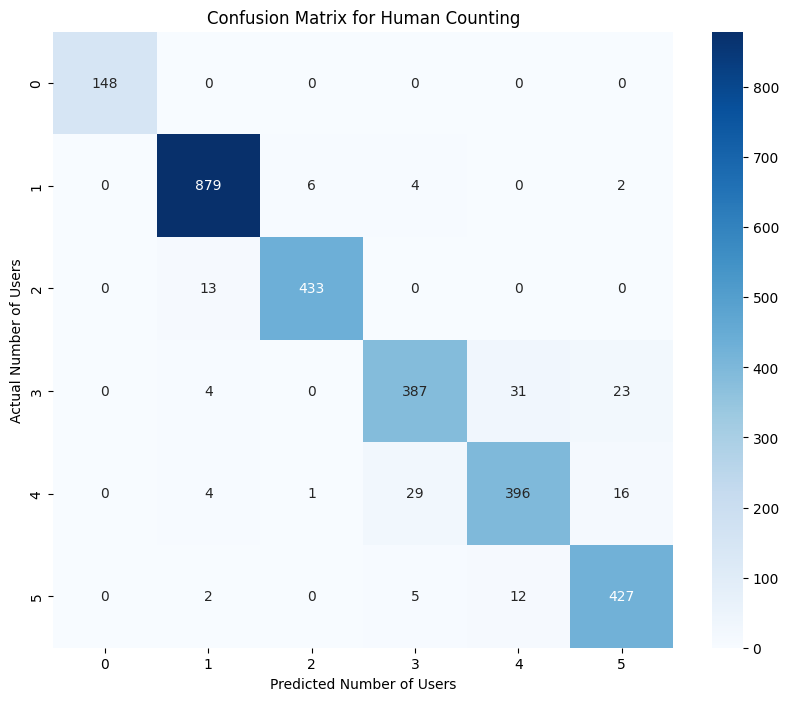

In [ ]:

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}\n")

#Print the classification report

print("Classification Report:")
print(classification_report(y_test, y_pred))

#Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted Number of Users')
plt.ylabel('Actual Number of Users')
plt.title('Confusion Matrix for Human Counting')
plt.show()